In [1]:
import pandas as pd
from pandas import read_csv
import os
from os import listdir
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')

os.chdir('/Users/xiaodanxu/Library/CloudStorage/GoogleDrive-arielinseu@gmail.com/My Drive/GEMS/BILD-AQ')

plt.style.use('ggplot')
sns.set(font_scale=1.4)  # larger font
m_to_mi = 0.000621371
m2_to_km2 = 1/1000000

In [2]:
# Load route inputs
nhts_routes_df = read_csv('data/Network/combined/nhts_thru_lengths_ordered_ccst_transp_geo_with_imputation.csv')
spillover_od_df = read_csv('data/Network/combined/NHTS_nonhome_OD_spillover.csv')
print(len(nhts_routes_df))
nhts_routes_df = pd.merge(nhts_routes_df, spillover_od_df,
                          on = ['o_geoid', 'd_geoid'], how = 'inner')
nhts_routes_df.loc[:, 'thru_length_tract'] *= m_to_mi
nhts_routes_df.loc[:, 'distance'] *= m_to_mi
nhts_routes_df.loc[:, 'thru_length_ccst'] *= m_to_mi
print(len(nhts_routes_df))
nhts_routes_df.head(5)

3560026
189858


,thru_geoid,o_geoid,d_geoid,thru_length_tract,distance,order,trip_id,thru_fid,o_fid,d_fid,thru_length_ccst,orig_st_code,dest_st_code,trpmiles,wtperfin
0,1003010400,1.003010e+09,1.209102e+10,16.502487,98.672935,1.0,32,11878.0,11878.0,11171.0,17.618224,AL,FL,81.221,297.119296
1,1003010400,1.003010e+09,1.209102e+10,16.502487,98.672935,1.0,32,11878.0,11878.0,11171.0,17.618224,AL,FL,81.221,375.362442
2,1003010904,1.003010e+09,1.209102e+10,13.168515,98.672935,2.0,32,10404.0,11878.0,11171.0,17.485077,AL,FL,81.221,297.119296
3,1003010904,1.003010e+09,1.209102e+10,13.168515,98.672935,2.0,32,10404.0,11878.0,11171.0,17.485077,AL,FL,81.221,375.362442
4,12033003603,1.003010e+09,1.209102e+10,1.115738,98.672935,3.0,32,11878.0,11878.0,11171.0,17.618224,AL,FL,81.221,297.119296


In [6]:
# load land area/lane mile inputs
network_attribute_df = read_csv('data/Network/combined/network_attributes.csv')
micro_geotype_label = read_csv('data/ccst_geoid_key_tranps_geo_with_imputation.csv')
micro_geotype_label = micro_geotype_label[['GEOID', 'geotype', 'microtype']]
# print(network_attribute_df.columns)
network_attribute_short = network_attribute_df[['GEOID', 'aland', 'lm_all_tract']]
nhts_routes_df = pd.merge(nhts_routes_df, network_attribute_short,
                          left_on = 'thru_geoid', 
                          right_on = 'GEOID',
                          how = 'left')

nhts_routes_df = pd.merge(nhts_routes_df, micro_geotype_label,
                          left_on = 'thru_geoid', 
                          right_on = 'GEOID',
                          how = 'left')
nhts_routes_df.head(5)

,thru_geoid,o_geoid,d_geoid,thru_length_tract,distance,order,trip_id,thru_fid,o_fid,d_fid,...,lm_all_tract_y,GEOID_y,geotype_y,microtype_y,GEOID_x,aland,lm_all_tract,GEOID_y,geotype,microtype
0,1003010400,1.003010e+09,1.209102e+10,16.502487,98.672935,1.0,32,11878.0,11878.0,11171.0,...,341.175720,1.003010e+09,C,5.0,1.003010e+09,737515790.0,341.175720,1.003010e+09,C,5.0
1,1003010400,1.003010e+09,1.209102e+10,16.502487,98.672935,1.0,32,11878.0,11878.0,11171.0,...,341.175720,1.003010e+09,C,5.0,1.003010e+09,737515790.0,341.175720,1.003010e+09,C,5.0
2,1003010904,1.003010e+09,1.209102e+10,13.168515,98.672935,2.0,32,10404.0,11878.0,11171.0,...,433.299440,1.003011e+09,C,3.0,1.003011e+09,276118423.0,433.299440,1.003011e+09,C,3.0
3,1003010904,1.003010e+09,1.209102e+10,13.168515,98.672935,2.0,32,10404.0,11878.0,11171.0,...,433.299440,1.003011e+09,C,3.0,1.003011e+09,276118423.0,433.299440,1.003011e+09,C,3.0
4,12033003603,1.003010e+09,1.209102e+10,1.115738,98.672935,3.0,32,11878.0,11878.0,11171.0,...,62.938667,1.203300e+10,C,5.0,1.203300e+10,93980034.0,62.938667,1.203300e+10,C,5.0


In [7]:
orig_states = nhts_routes_df.orig_st_code.unique()
nhts_routes_short = nhts_routes_df[['thru_geoid', 'o_geoid', 'd_geoid',
                                    'thru_length_tract', 'orig_st_code',
                                    'dest_st_code', 'wtperfin', 'aland', 
                                    'lm_all_tract', 'geotype', 'microtype']]
# print(orig_states)
nhts_routes_out = None
for st in orig_states:
    if pd.isna(st):
        continue
    print('processing state ' + st)
    nhts_routes_selected = nhts_routes_short.loc[nhts_routes_short['orig_st_code'] == st]
    dist_matrix = \
    read_csv('data/Network/combined/distance_matrix_by_tracts_' + st + '.csv')
    
    nhts_routes_selected = pd.merge(nhts_routes_selected,
                                    dist_matrix,
                                    left_on = ['o_geoid', 'thru_geoid'],
                                    right_on = ['origin', 'destination'],
                                    how = 'left')
    nhts_routes_selected = nhts_routes_selected.drop(columns = ['Unnamed: 0', 'origin', 'destination'])
    nhts_routes_out = pd.concat([nhts_routes_out, nhts_routes_selected])
#     break
nhts_routes_out.head(5)

processing state AL
processing state AK
processing state AZ
processing state AR
processing state CA
processing state CO
processing state CT
processing state DE
processing state DC
processing state FL
processing state GA
processing state HI
processing state ID
processing state IL
processing state IN
processing state IA
processing state KS
processing state KY
processing state LA
processing state ME
processing state MD
processing state MA
processing state MI
processing state MN
processing state MS
processing state MO
processing state MT
processing state NE
processing state NV
processing state NH
processing state NJ
processing state NM
processing state NY
processing state NC
processing state ND
processing state OH
processing state OK
processing state OR
processing state PA
processing state RI
processing state SC
processing state SD
processing state TN
processing state TX
processing state UT
processing state VT
processing state VA
processing state WA
processing state WV
processing state WI


,thru_geoid,o_geoid,d_geoid,thru_length_tract,orig_st_code,dest_st_code,wtperfin,aland,lm_all_tract,geotype,microtype,distance
0,1003010400,1.003010e+09,1.209102e+10,16.502487,AL,FL,297.119296,737515790.0,341.175720,C,5.0,0.000000
1,1003010400,1.003010e+09,1.209102e+10,16.502487,AL,FL,375.362442,737515790.0,341.175720,C,5.0,0.000000
2,1003010904,1.003010e+09,1.209102e+10,13.168515,AL,FL,297.119296,276118423.0,433.299440,C,3.0,10.619541
3,1003010904,1.003010e+09,1.209102e+10,13.168515,AL,FL,375.362442,276118423.0,433.299440,C,3.0,10.619541
4,12033003603,1.003010e+09,1.209102e+10,1.115738,AL,FL,297.119296,93980034.0,62.938667,C,5.0,19.393226


In [8]:
distance_bin = [-1, 5, 10, 20, 50, 100, 300]
distance_bin_label = ['bin1', 'bin2', 'bin3', 'bin4', 'bin5', 'bin6']
nhts_routes_out.loc[:, 'dist_bin'] = pd.cut(nhts_routes_out.loc[:, 'distance'],
                                            bins = distance_bin,
                                            labels = distance_bin_label,
                                            ordered = False)
nhts_routes_out.loc[:, 'thru_length_tract_wt'] = nhts_routes_out.loc[:, 'thru_length_tract'] * \
nhts_routes_out.loc[:, 'wtperfin']
nhts_routes_out.head(5)

,thru_geoid,o_geoid,d_geoid,thru_length_tract,orig_st_code,dest_st_code,wtperfin,aland,lm_all_tract,geotype,microtype,distance,dist_bin,thru_length_tract_wt
0,1003010400,1.003010e+09,1.209102e+10,16.502487,AL,FL,297.119296,737515790.0,341.175720,C,5.0,0.000000,bin1,4903.207169
1,1003010400,1.003010e+09,1.209102e+10,16.502487,AL,FL,375.362442,737515790.0,341.175720,C,5.0,0.000000,bin1,6194.413643
2,1003010904,1.003010e+09,1.209102e+10,13.168515,AL,FL,297.119296,276118423.0,433.299440,C,3.0,10.619541,bin3,3912.619801
3,1003010904,1.003010e+09,1.209102e+10,13.168515,AL,FL,375.362442,276118423.0,433.299440,C,3.0,10.619541,bin3,4942.965827
4,12033003603,1.003010e+09,1.209102e+10,1.115738,AL,FL,297.119296,93980034.0,62.938667,C,5.0,19.393226,bin3,331.507279


0.0


(0.0, 1000.0)

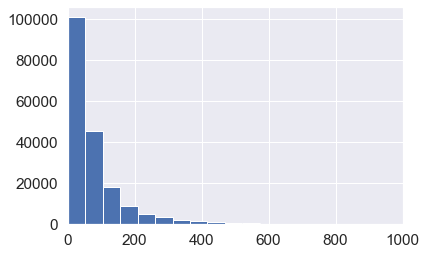

In [9]:
print(nhts_routes_out.loc[:, 'lm_all_tract'].min())
nhts_routes_out.loc[:, 'lm_all_tract'].hist(bins = 50)
plt.xlim([0, 1000])

In [11]:
# nhts_routes_out = nhts_routes_out.loc[nhts_routes_out['dist_bin'] != 'bin7']
vmt_acc_by_radius = \
nhts_routes_out.groupby(['dist_bin', 'geotype',	'microtype'])[['wtperfin', 'thru_length_tract_wt', 'aland', 'lm_all_tract']].sum()
vmt_acc_by_radius = vmt_acc_by_radius.reset_index()
vmt_acc_by_radius.loc[:, 'trip_fraction'] = \
vmt_acc_by_radius.loc[:, 'wtperfin'] / \
vmt_acc_by_radius.loc[:, 'wtperfin'].sum()

vmt_acc_by_radius.loc[:, 'vmt_fraction'] = \
vmt_acc_by_radius.loc[:, 'thru_length_tract_wt'] / \
vmt_acc_by_radius.loc[:, 'thru_length_tract_wt'].sum()
# vmt_acc_by_radius = vmt_acc_by_radius.loc[vmt_acc_by_radius['dist_bin'] != 'bin7']
vmt_acc_by_radius = vmt_acc_by_radius[['dist_bin', 'geotype', 'microtype', 'vmt_fraction']]
vmt_acc_by_radius.to_csv('state_spillover/nonhome_spillover_vmt_fraction_by_micro_geotype.csv', index = False)

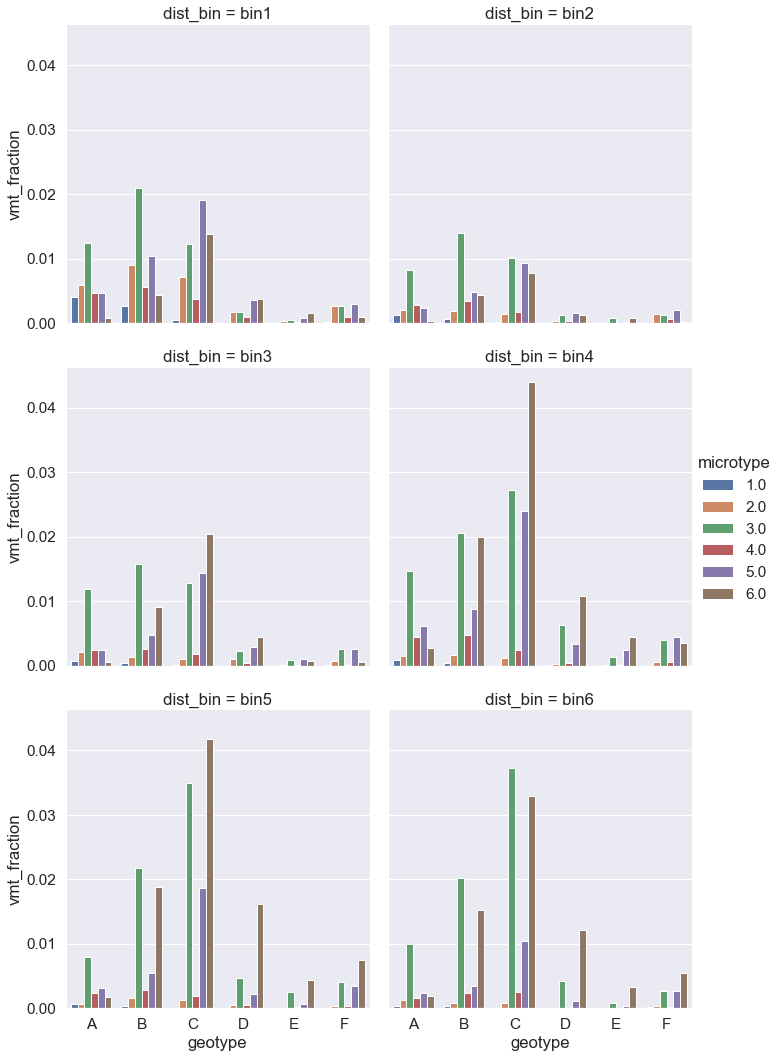

In [12]:
vmt_acc_by_radius['dist_bin'] = vmt_acc_by_radius['dist_bin'].astype(str)
sns.catplot(data = vmt_acc_by_radius, 
            x="geotype", 
            y="vmt_fraction", 
            hue="microtype", 
            col = 'dist_bin',
            col_wrap = 2,
            kind = 'bar')
plt.savefig('state_spillover/vmt_frac_by_micro_geotype.png', dpi = 200)

In [13]:
vmt_acc_by_radius = \
nhts_routes_out.groupby(['dist_bin'])[['wtperfin', 'thru_length_tract_wt', 'aland', 'lm_all_tract']].sum()
vmt_acc_by_radius = vmt_acc_by_radius.reset_index()
vmt_acc_by_radius.loc[:, 'trip_fraction'] = \
vmt_acc_by_radius.loc[:, 'wtperfin'] / \
vmt_acc_by_radius.loc[:, 'wtperfin'].sum()

vmt_acc_by_radius.loc[:, 'vmt_fraction'] = \
vmt_acc_by_radius.loc[:, 'thru_length_tract_wt'] / \
vmt_acc_by_radius.loc[:, 'thru_length_tract_wt'].sum()

vmt_acc_by_radius = vmt_acc_by_radius[['dist_bin', 'vmt_fraction']]
vmt_acc_by_radius.to_csv('state_spillover/nonhome_spillover_vmt_fraction.csv', index = False)

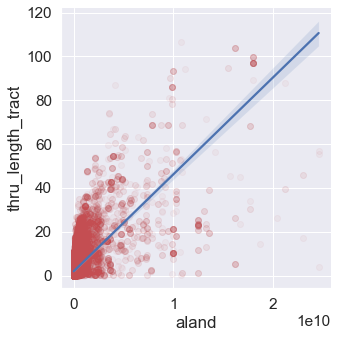

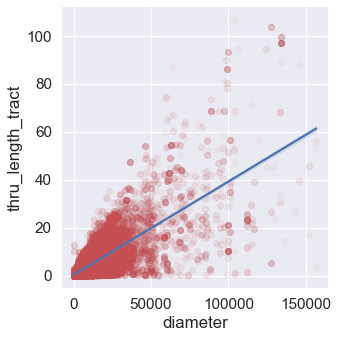

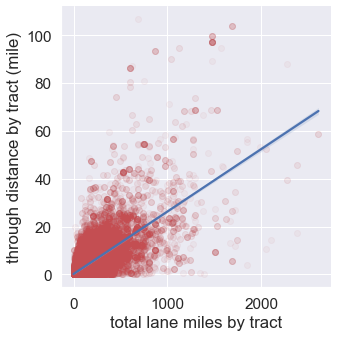

In [15]:

nhts_routes_out_with_lm = nhts_routes_out.loc[nhts_routes_out['lm_all_tract'] > 0] 
nhts_routes_out_with_lm.loc[:, 'diameter'] = np.sqrt(nhts_routes_out_with_lm.loc[:, 'aland'])
# nhts_routes_out_with_lm.loc[:, 'aland'] *= m2_to_km2
sns.lmplot(data = nhts_routes_out_with_lm, 
                x="aland", y="thru_length_tract",
               scatter_kws={'alpha':0.05, 'color': 'r'})
plt.show()

sns.lmplot(data = nhts_routes_out_with_lm, 
                x="diameter", y="thru_length_tract",
               scatter_kws={'alpha':0.05, 'color': 'r'})
plt.show()

sns.lmplot(data = nhts_routes_out_with_lm, 
                x="lm_all_tract", y="thru_length_tract",
               scatter_kws={'alpha':0.05, 'color': 'r'})
plt.xlabel('total lane miles by tract')
plt.ylabel('through distance by tract (mile)')
plt.savefig('state_spillover/nonhome_through_dist_vs_lane_mile.png')
plt.show()